In [1]:
import os
import math
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Немного о ресурсах в Spark

Spark управляет ресурсами через Driver, а ресурсы - распределенные Executors.

![](cwrMN.png)

`Executor` это рабочий процесс, который запускает индивидуальные заданий в общем Spark Job. Они запускаются с процессом, выполняют свою задачу и посылают результаты на `driver`. 

`Driver` это процесс осуществляющий контроль над запущенным Spark Job. Он конвертирует код в задачи и составляет расписание задач для `executors`.

Рабочий процесс, который они делуют на основе вашего года можно изобрать так:

- driver запрашивает ресурсы у cluster manager
- запускаются executors, если доступны выделеные ресурсы
- driver планирует работу и трансформирует ваш код в план выполнения
- executors выполняют задачу и отправляют отчет о своей работе на driver
- каждый процесс должен быть завершен и driver по нему должен получить результат (отчет), иначе процесс должен быть перезапущен driver'ом
- spark.stop() завершает работу и освобождает ресурсы.

![](1y2zm.png)


#### Сравним работу hadoop и spark

`Процесс работы Hadoop:`

![](Image-1.png)
![](Image-2.png)
![](Image-3.png)
![](Image-4.png)

-----------------------------------------

`Процесс работы Spark(client mode):`

![](Image-5.png)
![](Image-6.png)

`Процесс работы Spark(cluster mode):`

![](Image-7.png)
![](Image-8.png)


**Для режима cluster mode нужна интеграция с YARN**

Для этого нужны настроенные параметры в Spark для взаимодействия с Hadoop:

- настроить HADOOP_CONF_DIR переменную среды
- настроить SPARK_HOME переменную среды
- в SPARK_HOME/conf/spark-defaults.conf установить параметр spark.master в yarn: `spark.master | yarn`
- копировать SPARK_HOME/jars в hdfs для взаимодействия между нодами: `hdfs dfs -put *.jar /user/spark/share/lib`


Пример `.bashrc`:
```bash
export HADOOP_CONF_DIR=/<path of hadoop dir>/etc/hadoop
export YARN_CONF_DIR=/<path of hadoop dir>/etc/hadoop
export SPARK_HOME=/<path of spark dir>
export LD_LIBRARY_PATH=/<path of hadoop dir>/lib/native:$LD_LIBRARY_PATH
```

Добавить изменения в конфиг `spark-default.conf`:
```bash
spark.master yarn
spark.yarn.jars hdfs://path_to_master:9000/user/spark/share/lib/*.jar
spark.executor.memory 1g
spark.driver.memory 512m
spark.yarn.am.memory 512m
```


## Расчет параметров для Spark

In [4]:
# установите параметры кластера

# сколько хотите задействовать excecutors 
# (это может быть любое число от 1 до +inf, это нужно для расчетов в качестве индексов)
max_executor = 300            

# количествол узлов в кластере (запомним, что 1 Node = 1 Worker process)
# ед. - штук
nodes = 10
nodes = nodes - 1  

# количество процессоров на кластере (сумма по всем нодам) (в примере: вы будете использовать 1/3 от кластера)
# ед. - штук
cpu = 80
cpu = int((cpu - 1) / 3)

# количество ОЗУ на кластере (в примере: вы будете использовать 1/3 от кластера)
# ед. - мегабайт
memo = 1048576
memo = int((memo - 1024) / 3)

# установите коэффициент overhead памяти (здесь базовое значение)
overhead_coef = 0.1

# кол-во параллеризма - базовое количество партиций в RDD
parallelizm_per_core = 5

# фактор партиционирования в hdfs
partition_factor = 3

### Запомним!

Мы распеределяем ресурсы для Spark, надо учитывать, что Spark выполяет такие операции:

![](SXQHj.jpg)

In [5]:
# создаем DataFrame с установкой параметров (кол-во executors устанавливаем как нарастающее значение)
df = pd.DataFrame(dict(executors=np.arange(1, max_executor)))

# рассчёт кол-ва памяти на 1 executor
# можно использовать формулу NUM_CORES * ((EXECUTOR_MEMORY + MEMORY_OVERHEAD) / EXECUTOR_CORES) (результат Гб на executor)
# но здесь ещё один метод рассчета
df['total_memo_per_executor'] = np.floor((memo / df.executors) * 0.9)

# overhead по стандарту 10% от executor
df['total_memooverhead_per_executor'] = df['total_memo_per_executor'] * 0.10

# остаток не используемой памяти на ноде
df['unused_memo_per_node'] = memo - (df.executors * df['total_memo_per_executor'])

# сколько займет процессоров
df['total_core_per_executor'] = np.floor(cpu / df.executors)

# остаток процессоров на ноде
df['unused_core_per_nodes'] = cpu - (df.executors * df['total_core_per_executor'])

# расчет памяти на executor
df['overhead_memo'] = (df['total_memo_per_executor'] * overhead_coef)
df['executor_memo'] = df['total_memo_per_executor'] - df['overhead_memo']

# кол-во процессор на executor
df['executor_cores'] = np.floor(cpu / df.executors)

# минус 1 для driver
df['executor_instance'] = (df.executors *df['executor_cores']) - 1 

# расчитываем или меняем по коду в ручную (можно начать с 2 для parallelizm_per_core)
df['parallelism'] = df['executor_instance'] * df['executor_cores'] * parallelizm_per_core 
df['num_partitions'] = df['executor_instance'] * df['executor_cores'] * partition_factor

# % используемой памяти на кластере
df['used_memo_persentage'] = (1- ((df['overhead_memo'] + df['executor_memo']) / memo)) * 100
# % использумых процессоров на кластере
df['used_cpu_persentage'] = ((cpu - df['unused_core_per_nodes']) / cpu) * 100


df.head(10)

,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
0,1,314265.0,31426.5,34919.0,26.0,0.0,31426.5,282838.5,26.0,25.0,3250.0,1950.0,10.000172,100.000000
1,2,157132.0,15713.2,34920.0,13.0,0.0,15713.2,141418.8,13.0,25.0,1625.0,975.0,55.000229,100.000000
2,3,104755.0,10475.5,34919.0,8.0,2.0,10475.5,94279.5,8.0,23.0,920.0,552.0,70.000057,92.307692
3,4,78566.0,7856.6,34920.0,6.0,2.0,7856.6,70709.4,6.0,23.0,690.0,414.0,77.500115,92.307692
4,5,62853.0,6285.3,34919.0,5.0,1.0,6285.3,56567.7,5.0,24.0,600.0,360.0,82.000034,96.153846
5,6,52377.0,5237.7,34922.0,4.0,2.0,5237.7,47139.3,4.0,23.0,460.0,276.0,85.000172,92.307692
6,7,44895.0,4489.5,34919.0,3.0,5.0,4489.5,40405.5,3.0,20.0,300.0,180.0,87.142882,80.769231
7,8,39283.0,3928.3,34920.0,3.0,2.0,3928.3,35354.7,3.0,23.0,345.0,207.0,88.750057,92.307692
8,9,34918.0,3491.8,34922.0,2.0,8.0,3491.8,31426.2,2.0,17.0,170.0,102.0,90.000115,69.230769
9,10,31426.0,3142.6,34924.0,2.0,6.0,3142.6,28283.4,2.0,19.0,190.0,114.0,91.000160,76.923077


<AxesSubplot:title={'center':'Распределение значений по параметрам'}>

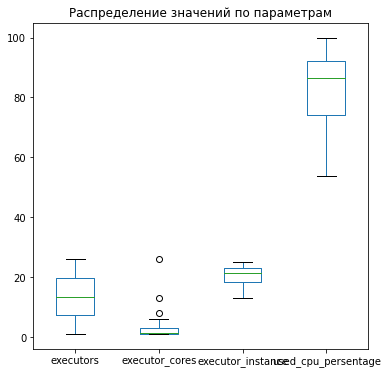

In [46]:
# посмотрим на графике распределение ресурсов
(df[(df['used_memo_persentage'] > 0)    & \
    (df['used_cpu_persentage'] > 0)     & \
    (df['used_memo_persentage'] <= 100) & \
    (df['used_cpu_persentage'] <= 100)  & \
    (df['executor_instance'] > 0)       & \
    (df['parallelism'] > 0)             & \
    (df['num_partitions'] > 0)          
    ])[['executors', 
        'executor_cores', 
        'executor_instance',
        'used_cpu_persentage'
       ]].plot(kind='box', figsize=(6,6), title='Распределение значений по параметрам')


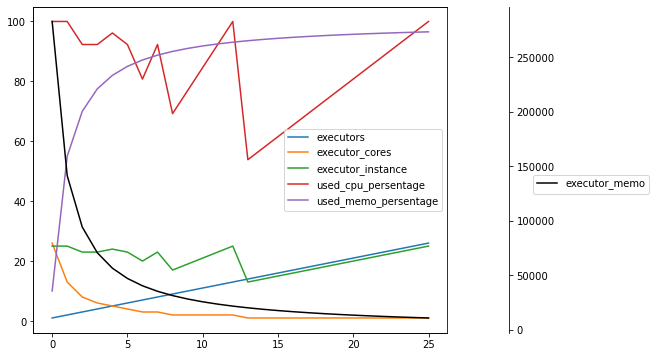

In [70]:
# посмотрим на графике распределение ресурсов
fig, ax = plt.subplots()
tdf1 = (df[(df['used_memo_persentage'] > 0)    & \
           (df['used_cpu_persentage'] > 0)     & \
           (df['used_memo_persentage'] <= 100) & \
           (df['used_cpu_persentage'] <= 100)  & \
           (df['executor_instance'] > 0)       & \
           (df['parallelism'] > 0)             & \
           (df['num_partitions'] > 0)          
            ])[['executors', 
                'executor_cores', 
                'executor_instance',
                'used_cpu_persentage',
                'used_memo_persentage'
               ]].plot(ax = ax,  figsize=(10, 6))

tdf2 = (df[(df['used_memo_persentage'] > 0)    & \
           (df['used_cpu_persentage'] > 0)     & \
           (df['used_memo_persentage'] <= 100) & \
           (df['used_cpu_persentage'] <= 100)  & \
           (df['executor_instance'] > 0)       & \
           (df['parallelism'] > 0)             & \
           (df['num_partitions'] > 0)          
            ])[[
                'executor_memo'
               ]]


ax2 = ax.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

tdf2.plot(ax=ax2, color='black')


ax2.legend(bbox_to_anchor=(1.5, 0.5))


In [6]:
# установите количество используйемой памяти и процессоров
# например: в расчете вы использовали 1/3 от доступных ресурсов (так как вас 3 человека на кластере)
# сделайте выбор всех доступных вам ресурсов

df_opt = df[(df['used_memo_persentage'] == df['used_memo_persentage'].max())]
df_opt.head()

# вы видете, что max() по ОЗУ превышает кол-во CPU и вы не можете использовать такие параметры

,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
298,299,1051.0,105.1,34935.0,0.0,26.0,105.1,945.9,0.0,-1.0,-0.0,-0.0,99.699013,0.0


In [7]:
# сделаем выбор по другим фильтрам (чтобы получить нормальные параметры)
# executor_instance
# parallelism
# num_partitions
# установим максимальное использование выделенных ресурсов.

df_opt = df[(df['executor_instance'] > 0)       & \
            (df['parallelism'] > 0)             & \
            (df['num_partitions'] > 0)]

df_opt = df_opt[(df_opt['used_memo_persentage'] == df_opt['used_memo_persentage'].max())]
df_opt


,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
25,26,12087.0,1208.7,34922.0,1.0,0.0,1208.7,10878.3,1.0,25.0,125.0,75.0,96.538501,100.0


In [8]:
# запишем параметры в переменные
sparkYarnExecutorMemoryOverhead = "{}Mb".format(df_opt['overhead_memo'].astype('int').values[0])
sparkExecutorsMemory = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0])
sparkDriverMemory = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0])
sparkDriverMaxResultSize = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0] if df_opt['executor_memo'].astype('int').values[0] <= 4080 else 4080)
sparkExecutorCores = "{}".format(df_opt['executor_cores'].astype('int').values[0])
sparkDriverCores = "{}".format(df_opt['executor_cores'].astype('int').values[0])
defParallelism = "{}".format(df_opt['parallelism'].astype('int').values[0])

In [10]:
sparkDriverMemory

'10878Mb'

In [37]:
# Добавим параметры 
# sparkDynamicAllocationEnabled при "true" будет динамическое выделение ресурсов на весь доступный объем
sparkDynamicAllocationEnabled = "true"
sparkShuffleServiceEnabled = "true"
# время освобождения ресурсов
sparkDynamicAllocationExecutorIdleTimeout = "60s"
# освобождение кэшированных данных
sparkDynamicAllocationCachedExecutorIdleTimeout = "600s"
# ограничиваем кол-во ресурсов на 1 spark session
sparkDynamicAllocationMaxExecutors = "{}".format(df_opt['executors'].astype('int').values[0])
sparkDynamicAllocationMixExecutors = "{}".format(int(df_opt['executors'].values[0] /10))
# устанавливаем сериалайзер
sparkSerializer = "org.apache.spark.serializer.KryoSerializer"
# перебераем порты для соединения, вдруг что-то будет занято
sparkPortMaxRetries = "10"
# архивируем папку spark и загружаем на hdfs для ускорения работы 
sparkYarnArchive = "hdfs:///nes/spark.zip" 
# устанавливаем работы GC
sparkExecutorExtraJavaOptions = "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'",
spark.driver.extraJavaOptions = "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'",
yarnNodemanagerVmem_check_enabled = "false",
yarnNodemanagerPmem_check_enabled = "false"